In [1]:
from agents import ModelAverager, DeltaHedge, DRLAgent
from discrete_environments import DiscreteEnv, DiscreteEnv2
from data_generators import GBM_Generator, HestonGenerator
import utils
import numpy as np
import matplotlib.pyplot as plt

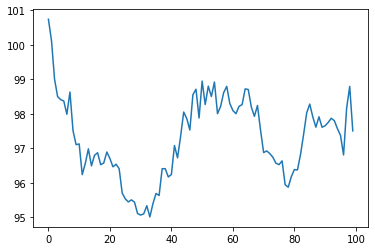

In [23]:
gen = HestonGenerator(S0 = 100, r = 0.03, V0 = 0.2*0.2, rho = 0.7, kappa = 5.0, theta = 0.04, xi = 0.9, freq = 0.2)
gen.reset()
path = []
for _ in range(100):

    path.append(gen.get_next())

plt.plot(path)

In [60]:
S0 = 100

# Annualized
sigma = 0.01*np.sqrt(250) # 1% vol per day
r = 0.0

freq = 0.2 # corresponds to trading freq of 5x per day
ttm = 50
kappa = 0.0
cost_multiplier = 0.0
gamma = 0.88

generator = GBM_Generator(S0, r, sigma, freq)

env_args = {
    "generator" : generator,
    "ttm" : ttm,
    "kappa" : kappa,
    "cost_multiplier" : cost_multiplier,
    "testing" : False
}

n_steps = 15000
n_batches = 5

eps_func = utils.EpsFunction(n_steps).get_func()

In [61]:
env = DiscreteEnv(**env_args)
drl_env, _ = env.get_sb_env()
agent = ModelAverager(env, gamma)


C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


In [62]:
total_timesteps = 1000000
n_eval_episodes = 100

DQN_PARAMS = {
    "buffer_size": 750000,
    "learning_rate": 0.0001, # utils.custom_schedule(0.0001, 0.0004, 0.00001, 0.75),
    "learning_starts": 50000,
    "exploration_fraction": 1.0,
    "exploration_final_eps": 0.05,
    "gamma": 0.9,
    "target_update_interval" : 30000,
    "train_freq": 50,
    "tau": 0.8,
    "batch_size": 128,
    "max_grad_norm": 1.0
}

PPO_PARAMS = {
    "n_steps": 5000, # how many transitions to do before updating network
    "n_epochs": 30, # number of epochs for SGD update
    "batch_size": 4096, # batch size of SGD update
    # how to update policy:
    "target_kl":0.005, # [0.003, 0.03]
    "max_grad_norm" : 1.0, # in Du paper
    # 'reward shaping'
    "gae_lambda" : 0.92, # [0.9,1]
    "gamma":0.88, # [0.8,1]

    "vf_coef":0.8, # [0.5,1], 0.5 in Du
    "ent_coef": 0.02, # [0,0.01], 0.2 in Du
    
    "learning_rate": 0.0001
}

model_kwargs = PPO_PARAMS

policy_kwargs = {
    "net_arch": [15,15,15]
}

drl_agent = DRLAgent(drl_env)
model = drl_agent.get_model('ppo', verbose=1, model_kwargs=model_kwargs, policy_kwargs=policy_kwargs)

trained_model = drl_agent.train_model(model=model, 
                                tb_log_name='ppo',
                                total_timesteps=total_timesteps,
                                n_eval_episodes=n_eval_episodes)


{'n_steps': 5000, 'n_epochs': 30, 'batch_size': 4096, 'target_kl': 0.005, 'max_grad_norm': 1.0, 'gae_lambda': 0.92, 'gamma': 0.88, 'vf_coef': 0.8, 'ent_coef': 0.02, 'learning_rate': 0.0001}
Using cpu device
Logging to tensorboard_log/ppo\ppo_12


C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\stable_baselines3\ppo\ppo.py:138: UserWarning: You have specified a mini-batch size of 4096, but because the `RolloutBuffer` is of size `n_steps * n_envs = 5000`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 904
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=5000 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


-----------------------------
| time/              |      |
|    fps             | 1200 |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 5000 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1178          |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 10000         |
| train/                  |               |
|    approx_kl            | 0.00024707196 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.62         |
|    explained_variance   | 0.000362      |
|    learning_rate        | 0.0001        |
|    loss                 | 817           |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.00219      |
|    value_loss           | 1.06e+03      |
------------------------------------------

In [63]:
# Careful here: testing=true affects following training
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq=freq, seed = 1334)
env_args["generator"] = generator
env_args["testing"] = True

test_env = DiscreteEnv(**env_args)

# Trained Net prediction
df = DRLAgent.Prediction(
    model=trained_model, 
    environment = test_env,
    pred_args = {"deterministic":True})

df = df['output']

hit end!


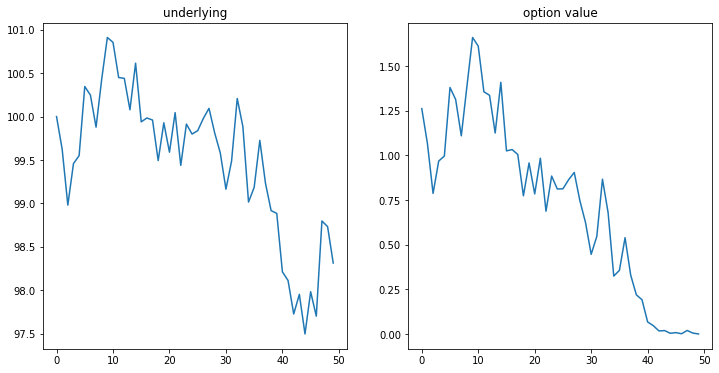

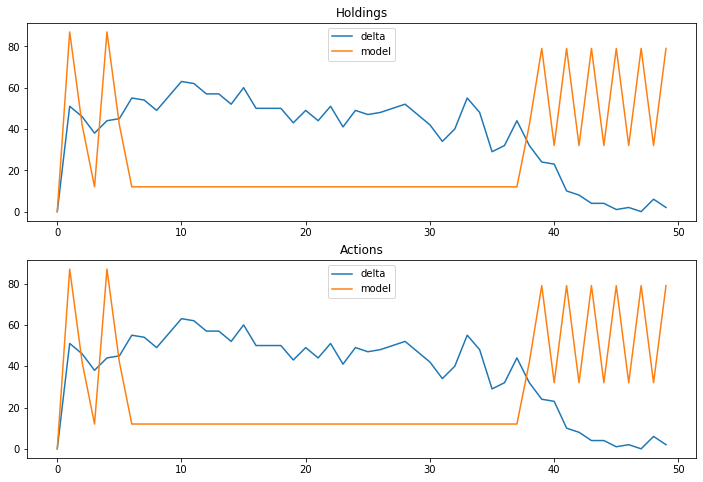

In [64]:
test_env_delta = DiscreteEnv(**env_args)
delta_agent = DeltaHedge(r, sigma, S0)
delta = delta_agent.test(test_env_delta)

utils.plot_decisions(delta, df)

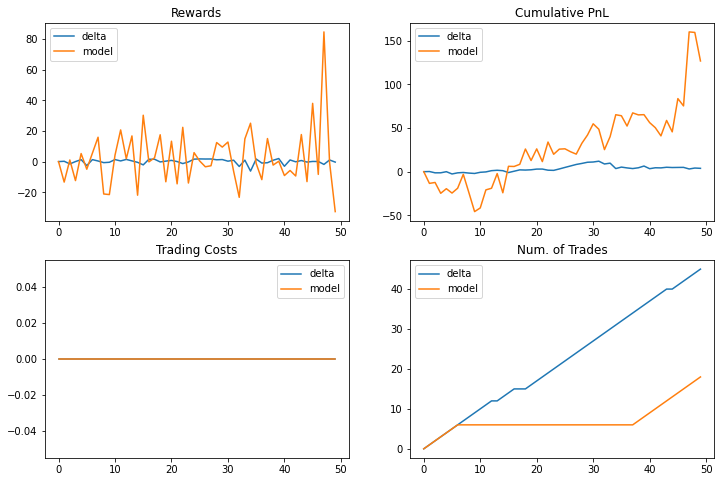

In [65]:
utils.plot_pnl(delta, df)

C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


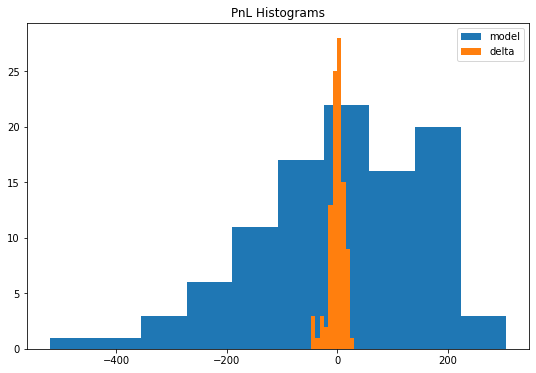

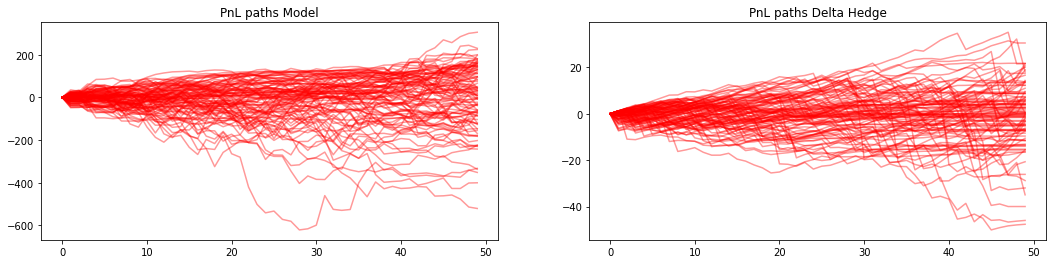

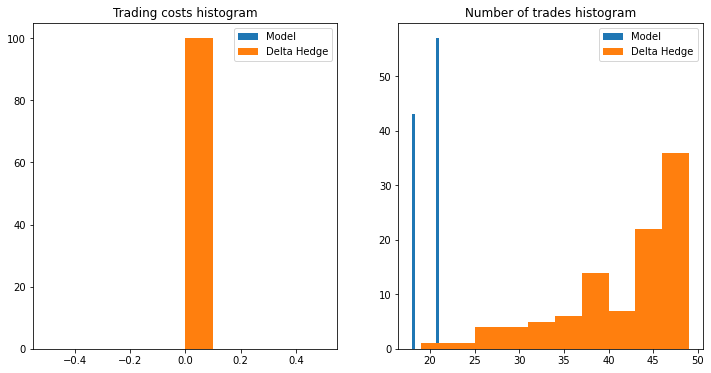

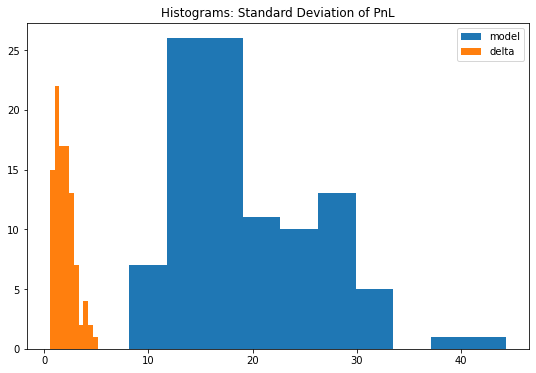

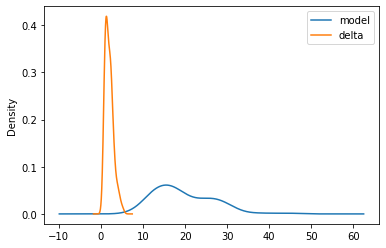

In [66]:
isDRL = True
n_sim = 100
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq = freq)
env_args["generator"] = generator
env_args["testing"] = True
pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict = utils.simulate_pnl(trained_model, delta_agent, n_sim, isDRL, env_args)
utils.plot_pnl_hist(pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict)

## Regression Tree training

In [5]:
# graph = agent.train(n_steps, n_batches, eps_func)
# graph
agent.train(n_steps, n_batches, eps_func)

100%|██████████| 15000/15000 [00:59<00:00, 252.62it/s]


C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


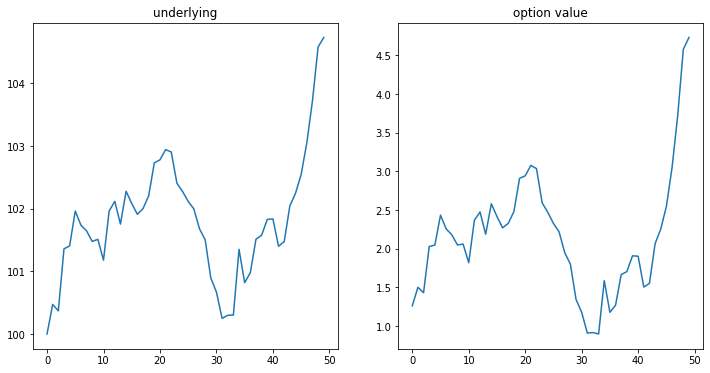

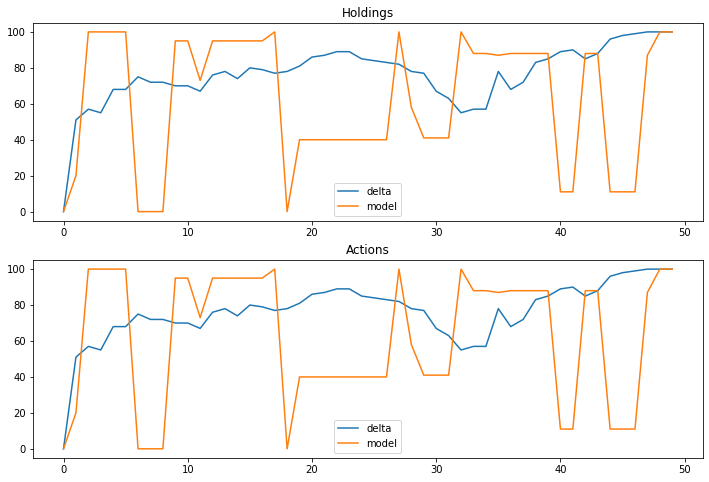

In [6]:
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq=freq, seed = 1234)
env_args["generator"] = generator
env_args["testing"] = True

test_env = DiscreteEnv(**env_args)
test_env_delta = DiscreteEnv(**env_args)

df = agent.test(test_env)

delta_agent = DeltaHedge(r, sigma, S0)
delta = delta_agent.test(test_env_delta)

utils.plot_decisions(delta, df)

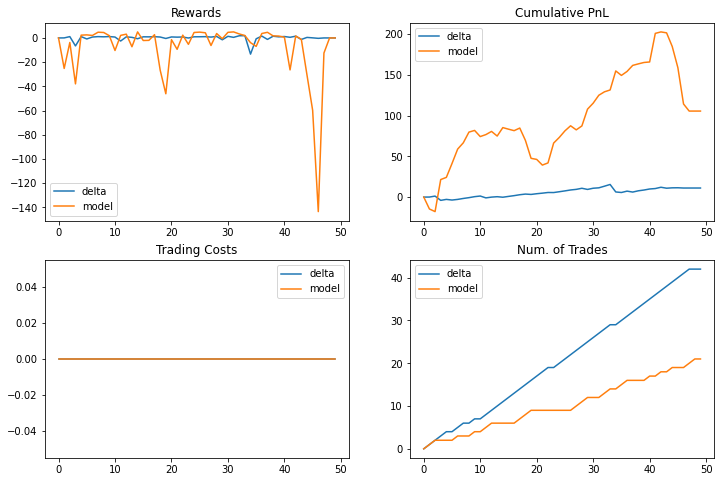

In [7]:
utils.plot_pnl(delta, df)

C:\Users\Adam\anaconda3\envs\rl1\lib\site-packages\gym\spaces\box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


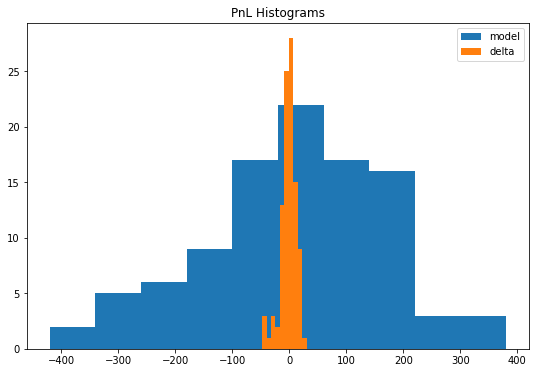

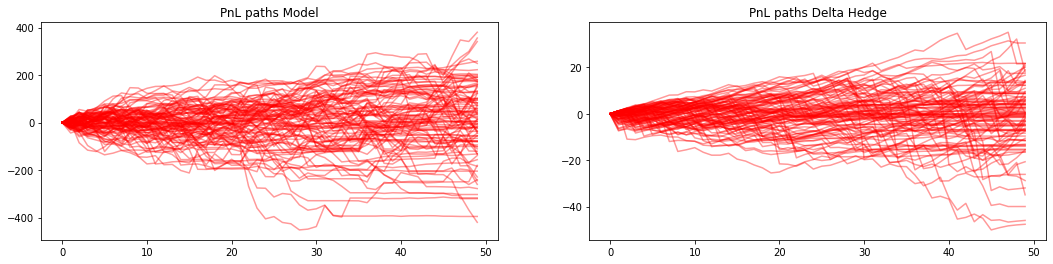

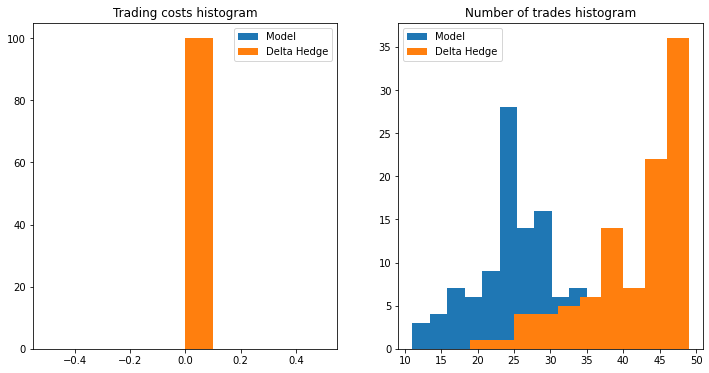

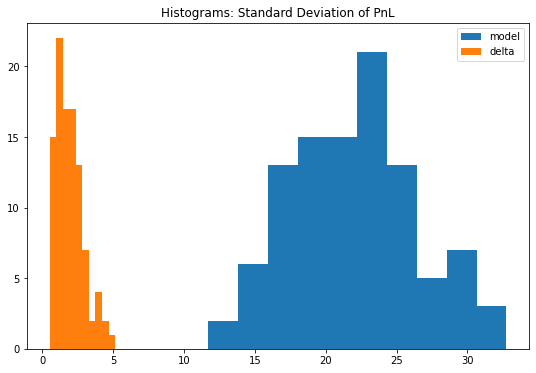

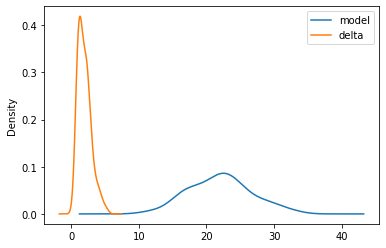

In [9]:
n_sim = 100
generator = GBM_Generator(r = r, sigma = sigma, S0 = S0, freq = freq)
env_args["generator"] = generator
env_args["testing"] = True
pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict = utils.simulate_pnl(agent, delta_agent, n_sim, False, env_args)
utils.plot_pnl_hist(pnl_paths_dict, pnl_dict, tcosts_dict, ntrades_dict)